# Generalized Poisson Distribution

The **Poisson** distribution models count data where the mean is equal to the variance.

The **Negative Binomial** distribution allows us to model overdispersed count data. 2 parameters:
- $\mu > 0$ mean
- $\alpha > 0$ overdispersion parameter: as $\alpha \rightarrow \infty$, Neg Bin converges to Poisson

We want our model to be able to fit underdispersed count data so that we can get tighter interval estimates. The **Generalized Poisson** distribution is flexible enough to handle both overdispersion and underdispersion.

$$f(y | \theta, \lambda) = \frac{\theta (\theta + \lambda y)^{y-1} e^{-\theta - \lambda y}}{y!}, y = 0,1,2,...$$

- When $\lambda = 0$, the Gen Poisson reduces to the standard Poisson with $\mu = \theta$
- When $\lambda < 0$, the model has underdispersion
- When $\lambda > 0$, the model has overdispersion

This notebook gives a sketch of the code to implement this distribution in PyMC3. The model is the same as what I show in the AR model notebook, but with the Generalized Poisson in place of the Poisson, and the prior for $\lambda$ set to

$$\lambda \sim \text{TruncatedNormal}(0, 0.1, \text{lower}=-1, \text{upper}=1)$$

### References
General info on the generalized poisson:
- https://www.tandfonline.com/doi/pdf/10.1080/03610929208830766
- https://journals.sagepub.com/doi/pdf/10.1177/1536867X1201200412
- https://towardsdatascience.com/generalized-poisson-regression-for-real-world-datasets-d1ff32607d79

Random sampling algorithms:
- https://www.tandfonline.com/doi/abs/10.1080/01966324.1997.10737439?journalCode=umms20

Creating a custom distribution in PyMC3:
- https://discourse.pymc.io/t/examples-of-random-in-custom-distribution/1263
- https://docs.pymc.io/notebooks/getting_started.html#Arbitrary-deterministics
- https://discourse.pymc.io/t/boolean-operations-support-for-theano-tensor/159

In [1]:
%matplotlib inline
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import theano.tensor as tt
from pymc3.distributions.dist_math import bound, logpow, factln
from pymc3.distributions.distribution import draw_values, generate_samples

In [2]:
df = pd.read_csv('../mass_dot_gov_datasets/st_elizabeths_medical_center_2020-04-29_to_2020-06-22.csv')
y = df['hospitalized_total_covid_patients_suspected_and_confirmed_including_icu'].astype(float)
T = len(y)
W = 2 # window size
F = 7 # num days of forecasts

### PMF

$$f(y | \theta, \lambda) = \frac{\theta (\theta + \lambda y)^{y-1} e^{-\theta - \lambda y}}{y!}, y = 0,1,2,...$$
where $\theta > 0$ and $\max(-1, -\frac{\theta}{4}) \leq \lambda \leq 1$

In [3]:
def genpoisson_logp(theta, lam):
    def logp_(value):
        log_prob = bound(tt.log(theta) + logpow(theta + lam * value, value - 1)
                         - (theta + lam * value) - factln(value),
                         value >= 0)
        # Return zero when value > m, where m is the largest pos int for which theta + m * lam > 0 (when lam < 0)
        # Also return zero when theta and value are both zero
        return tt.switch(theta + value * lam <= 0,
                         0, log_prob)
    return logp_

In [4]:
with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.01)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=0.01)
        rho.append(beta)
    f = pm.AR('f', rho, sigma=0.01, constant=True, shape=T+F)

    lam = pm.TruncatedNormal('lam', mu=0, sigma=0.1, lower=-1, upper=1)
    
    y_past = pm.DensityDist('y_past',
                            genpoisson_logp(tt.exp(f[:T]), lam),
                            observed=y)
    y_logp = pm.Deterministic('y_logp', y_past.logpt)

In [5]:
with model:
    trace = pm.sample(5000, tune=1000, random_seed=42, cores=1, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, f, beta[2], beta[1], beta[0]]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [03:31<00:00, 28.30it/s]
The number of effective samples is smaller than 25% for some parameters.


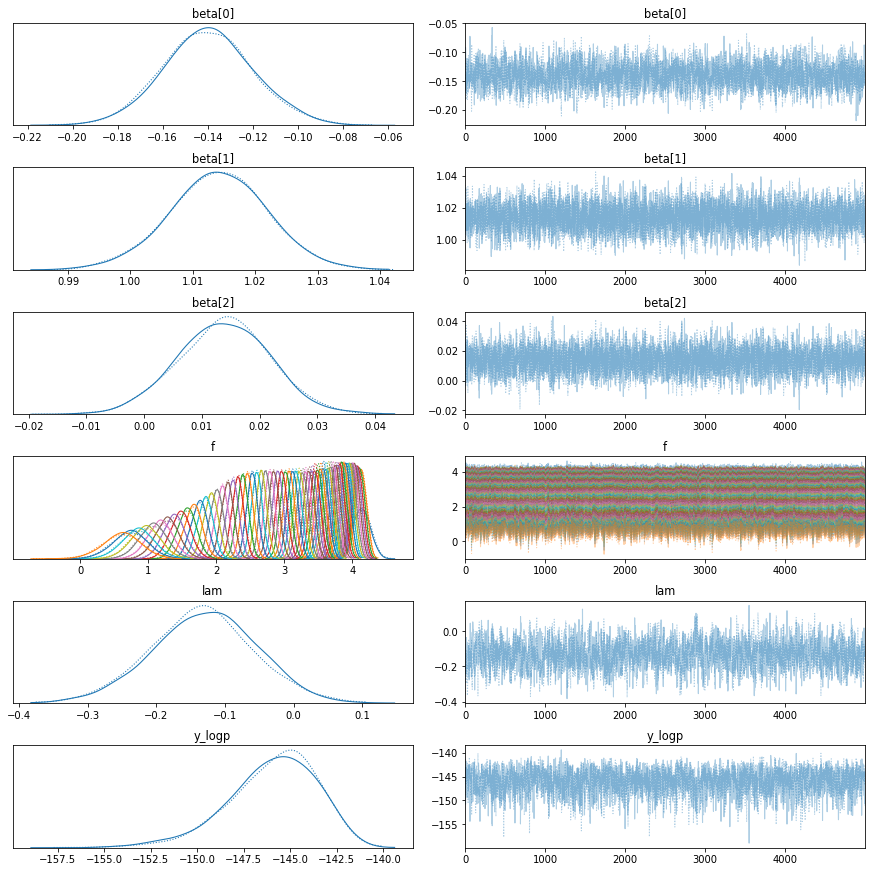

In [6]:
pm.traceplot(trace);

In [7]:
summary = pm.summary(trace)['mean'].to_dict()
for i in range(W+1):
    print(f'beta[{i}]', summary[f'beta[{i}]'])
print('lambda', summary['lam'])
print('\nTraining score:')
print(np.log(np.mean(np.exp(trace.get_values('y_logp', chains=0)))) / T)
print(np.log(np.mean(np.exp(trace.get_values('y_logp', chains=1)))) / T)

beta[0] -0.14
beta[1] 1.014
beta[2] 0.014
lambda -0.131

Training score:
-2.619998721401158
-2.619750715097662


### Random Sampling Algorithm
Inversion Algorithm presented in Felix Famoye (1997) Generalized Poisson Random Variate Generation

Initialize $\omega \leftarrow e^{-\lambda}$
1. $X \leftarrow 0$
2. $S \leftarrow e^{-\theta}$ and $P \leftarrow S$
3. Generate $U$ from uniform distribution on $(0,1)$.
4. While $U > S$, do
    1. $X \leftarrow X + 1$
    2. $C \leftarrow \theta - \lambda + \lambda X$
    3. $P \leftarrow \omega \cdot C (1 + \frac{\lambda}{C})^{X-1} P X^{-1}$
    4. $S \leftarrow S + P$
5. Deliver $X$

In [8]:
def genpoisson_rvs(theta, lam, size=None):
    if size is not None:
        assert size == theta.shape
    else:
        size = theta.shape
    lam = lam[0]
    omega = np.exp(-lam)
    X = np.full(size, 0)
    S = np.exp(-theta)
    P = np.copy(S)
    for i in range(size[0]):
        U = np.random.uniform()
        while U > S[i]:
            X[i] += 1
            C = theta[i] - lam + lam * X[i]
            P[i] = omega * C * (1 + lam/C)**(X[i]-1) * P[i] / X[i]
            S[i] += P[i]
    return X

In [9]:
with model:
    def genpoisson_rand(point=None, size=None):
        f_, lam_ = draw_values([f, lam], point=point)
        theta_ = np.exp(f_[T:])
        return generate_samples(genpoisson_rvs,
                                theta=theta_,
                                lam=lam_, size=size)
    
    y_future = pm.DensityDist('y_fut',
                              genpoisson_logp(theta=tt.exp(f[T:]), lam=lam),
                              random=genpoisson_rand,
                              shape=F)

In [10]:
with model:
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_future])
    
samples = forecasts['y_fut']

100%|██████████| 10000/10000 [00:08<00:00, 1200.31it/s]


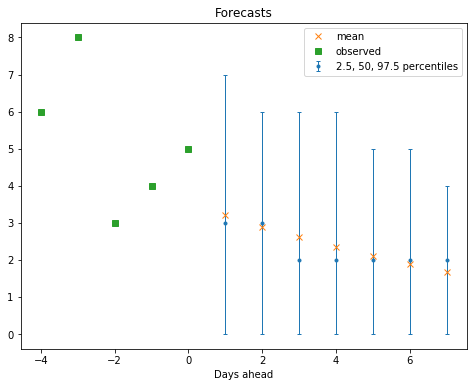

In [11]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

plt.figure(figsize=(8,6))
x_future = np.arange(1,F+1)
plt.errorbar(x_future, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(x_future, mean, 'x', label='mean');
x_past = np.arange(-4,1)
plt.plot(x_past, y[-5:], 's', label='observed')
plt.legend();
plt.title('Forecasts');
plt.xlabel('Days ahead');